# Import neccesary packages and Define Helper Packages

In [38]:
import os, numpy as np, pandas as pd
from transformers import pipeline, VisionTextDualEncoderModel, VisionTextDualEncoderProcessor, AutoTokenizer, AutoImageProcessor
from PIL import Image
from sklearn.metrics import roc_auc_score, classification_report

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [2]:
def plot_image_grid(images, ncols=None, cmap='gray'):
    '''Plot a grid of images'''
    if not ncols:
        factors = [i for i in range(1, len(images)+1) if len(images) % i == 0]
        ncols = factors[len(factors) // 2] if len(factors) else len(images) // 4 + 1
    nrows = int(len(images) / ncols) + int(len(images) % ncols)
    imgs = [images[i] if len(images) > i else None for i in range(nrows * ncols)]
    f, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
    axes = axes.flatten()[:len(imgs)]
    
    for img, ax in zip(imgs, axes.flatten()): 
        if np.any(img):
            if len(img.shape) > 2 and img.shape[2] == 1:
                img = img.squeeze()
            ax.imshow(img, cmap=cmap)

# Connect to the Data Set

In [3]:
data_dir = "all_images"

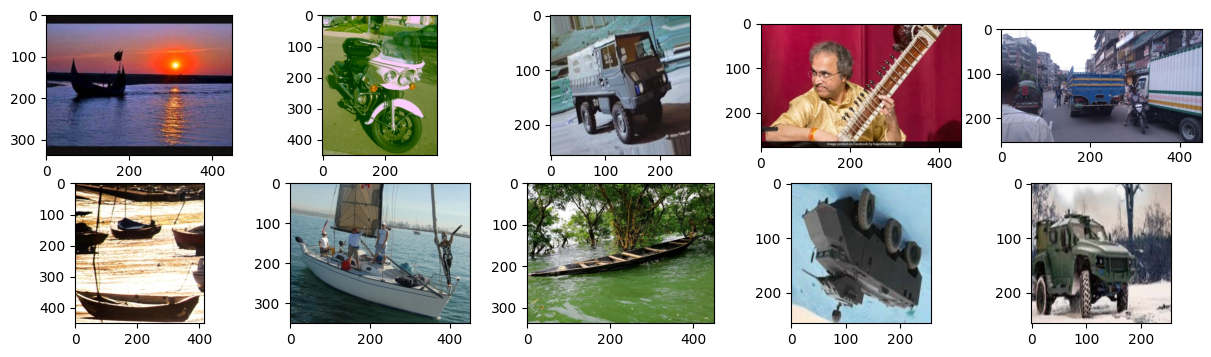

In [4]:
img_examples = [os.path.join(data_dir,i) for i in np.random.choice(os.listdir(data_dir), size=10)]

plot_image_grid([mpimg.imread(i) for i in img_examples])

In [5]:
mil_file_names = ['Armored personnel carriers', 'light utility vehicles', 'Anti-aircraft', 'war_tank', 'artillery', 'tanks', 'Prime movers', 'soldier']

# Zero-shot Image Labeling

In [6]:
checkpoint = "openai/clip-vit-large-patch14"
classifier = pipeline(model=checkpoint, task="zero-shot-image-classification", device=0)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [10]:
img_files = [os.path.join(data_dir,i) for i in np.random.choice(os.listdir(data_dir), size=1000)]
img_labels = np.max([[1 if i in filename else 0 for i in mil_file_names] for filename in img_files], axis=1)

candidate_labels = ["military", "non-military"]

threshold= 0.5

In [11]:
results = classifier(img_files, candidate_labels=candidate_labels)

In [12]:
mil_results = np.array([[i['score'] for i in res if i['label'] == "military"] for res in results]).flatten()
mil_results_files = [img_files[i] for i in np.where(mil_results > threshold)[0]]

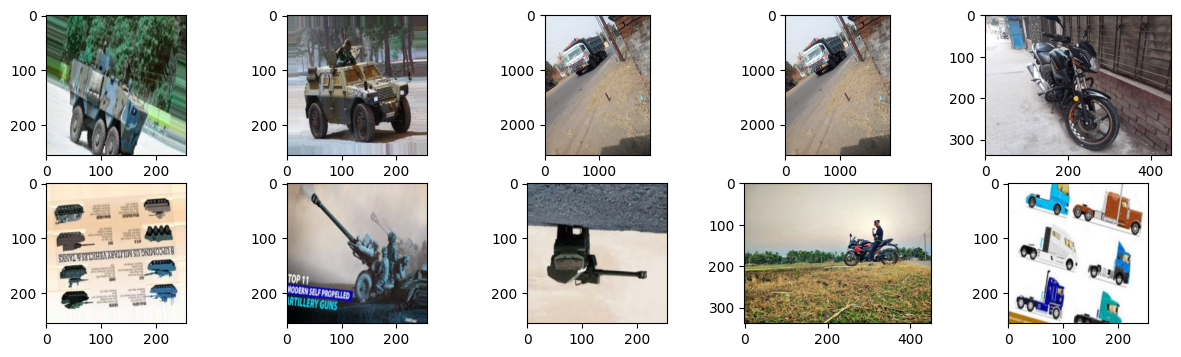

In [13]:
plot_image_grid([mpimg.imread(i) for i in mil_results_files][:10])

In [14]:
roc_auc_score(img_labels, mil_results)

0.902332865825152

In [15]:
print(classification_report(img_labels, mil_results >threshold))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83       690
           1       0.61      0.87      0.72       310

    accuracy                           0.79      1000
   macro avg       0.77      0.81      0.77      1000
weighted avg       0.83      0.79      0.80      1000



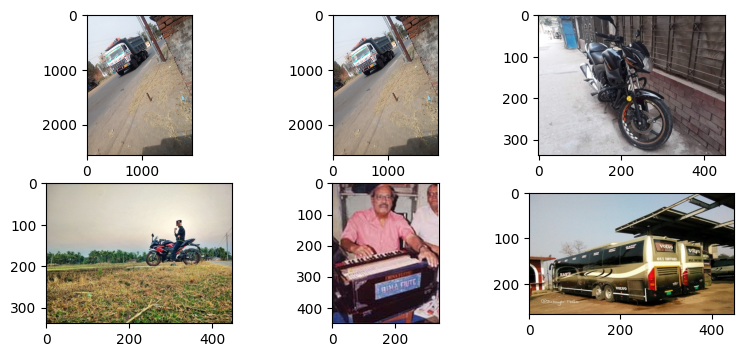

In [16]:
wrong_results = [img_files[i] for i in np.where( (img_labels - np.where(mil_results > threshold, 1,0)) !=0)[0]]
plot_image_grid([mpimg.imread(i) for i in wrong_results][:6])

# Prompt Engineering for Better Performance
- using more specific prompts (e.g. `["military vehicle", "soldier", "truck", "car", "boat", "motorcycle", "bus"]`)
- providing context (e.g. `["picture of a military vehicle","picture of a soldier", "picture of a truck", "picture of a car", "picture of a boat", 
"picture of a motorcycle", "sketch of a military vehicle"]`)

In [19]:
img_files = [os.path.join(data_dir,i) for i in np.random.choice(os.listdir(data_dir), size=1000)]
img_labels = np.max([[1 if i in filename else 0 for i in mil_file_names] for filename in img_files], axis=1)

candidate_labels = ["military vehicle", "soldier", "truck", "car", "boat", "motorcycle", "bus"]

threshold= 0.5

In [20]:
results = classifier(img_files, candidate_labels=candidate_labels)

In [27]:
mil_results = np.array([[i['score'] for i in res if i['label'] in ["military vehicle", "soldier"]] for res in results])
mil_results_files = [img_files[i] for i in np.where(np.max(mil_results, axis=1) >threshold)[0]]

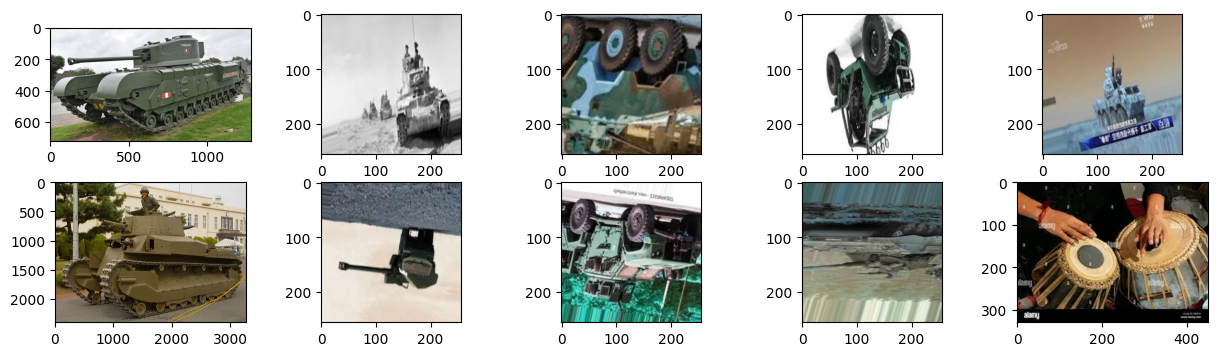

In [29]:
plot_image_grid([mpimg.imread(i) for i in mil_results_files][:10])

In [32]:
roc_auc_score(img_labels, np.max(mil_results, axis=1))

0.955438718696177

In [33]:
print(classification_report(img_labels, np.max(mil_results, axis=1) >threshold))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       701
           1       0.83      0.84      0.84       299

    accuracy                           0.90      1000
   macro avg       0.88      0.89      0.88      1000
weighted avg       0.90      0.90      0.90      1000



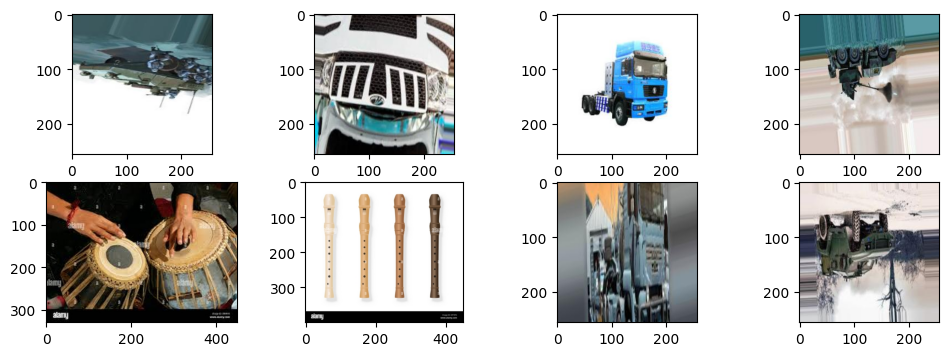

In [35]:
wrong_results = [img_files[i] for i in np.where( (img_labels - np.where(np.max(mil_results, axis=1) > threshold, 1,0)) !=0)[0]]
plot_image_grid([mpimg.imread(i) for i in wrong_results][:8])

# Fine Tuning the Model
- need to create a data  module - bonus if you can get it to do image augmentation, which then goes into the processor
- 

In [52]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification
import requests

model = AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-large-patch14")
processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [53]:
urls = [
    "http://images.cocodataset.org/val2017/000000039769.jpg",
    "https://farm3.staticflickr.com/2674/5850229113_4fe05d5265_z.jpg",
]

In [54]:
images = [Image.open(requests.get(url, stream=True).raw) for url in urls]
inputs = processor(
    text=["a photo of a cat", "a photo of a dog"], images=images, return_tensors="pt", padding=True
)

In [55]:
outputs = model(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    pixel_values=inputs.pixel_values,
    return_loss=True,
)

In [57]:
outputs.loss

tensor(0.0123, grad_fn=<DivBackward0>)

In [63]:
inputs

{'input_ids': tensor([[49406,   320,  1125,   539,   320,  2368, 49407],
        [49406,   320,  1125,   539,   320,  1929, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1]]), 'pixel_values': tensor([[[[ 5.8728e-01,  5.8728e-01,  6.1648e-01,  ...,  6.1738e-02,
            4.7139e-02, -2.5853e-02],
          [ 5.7268e-01,  5.7268e-01,  6.6027e-01,  ...,  1.2013e-01,
            7.6336e-02,  9.0935e-02],
          [ 5.8728e-01,  5.4349e-01,  6.1648e-01,  ...,  3.2541e-02,
            1.2013e-01,  6.1738e-02],
          ...,
          [ 1.8719e+00,  1.8573e+00,  1.8719e+00,  ...,  1.3902e+00,
            1.4340e+00,  1.4194e+00],
          [ 1.8281e+00,  1.8719e+00,  1.8427e+00,  ...,  1.4486e+00,
            1.4340e+00,  1.5070e+00],
          [ 1.8573e+00,  1.9011e+00,  1.8281e+00,  ...,  1.3756e+00,
            1.3610e+00,  1.4486e+00]],

         [[-1.3169e+00, -1.3019e+00, -1.3169e+00,  ..., -1.4970e+00,
           -1.4369e+00, -1.4820e+00],
  

# Saving and Loading Models